KeyError: 0

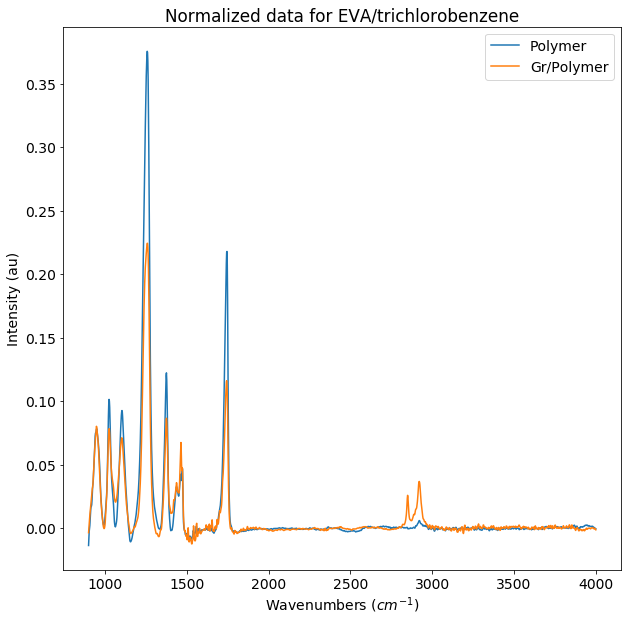

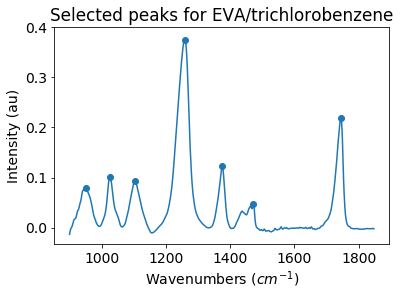

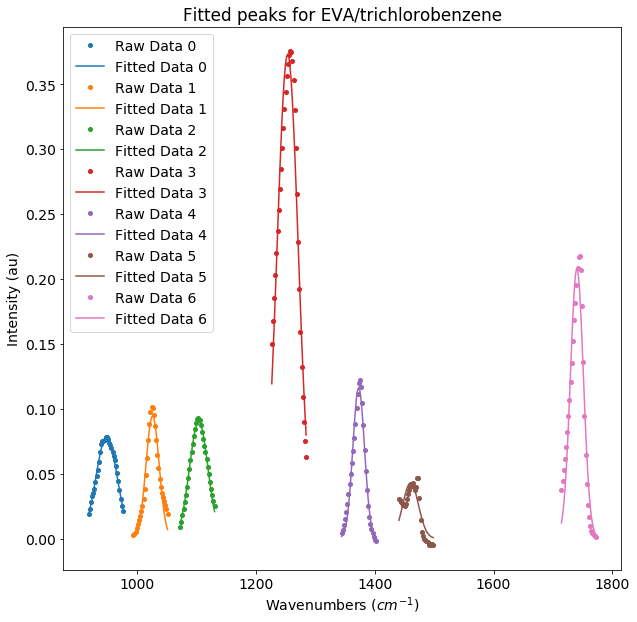

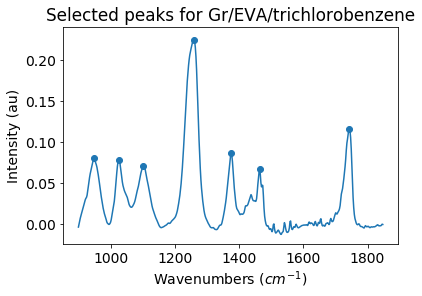

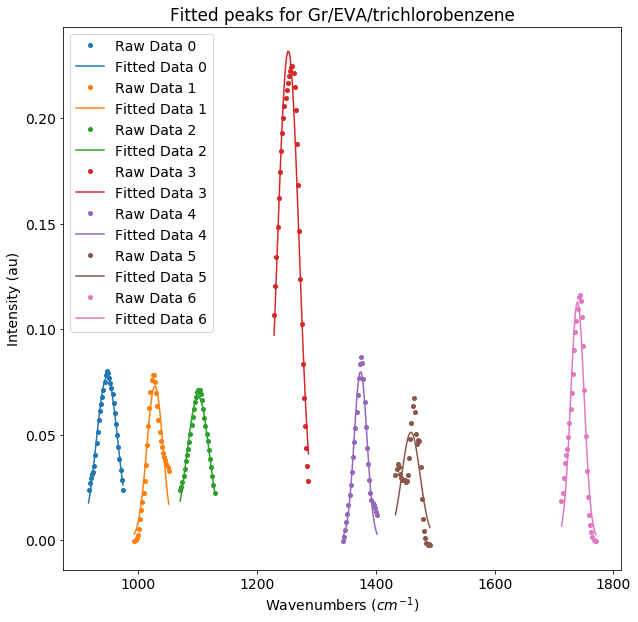

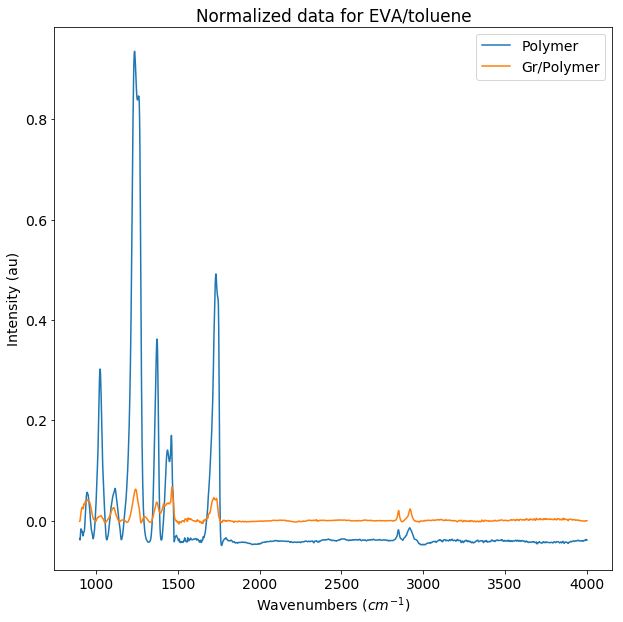

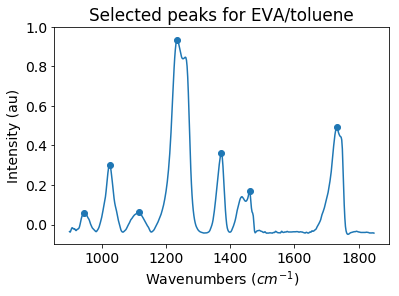

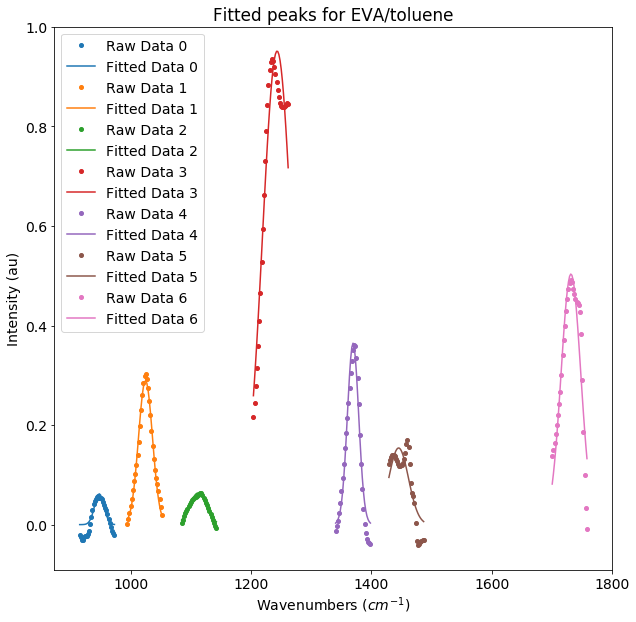

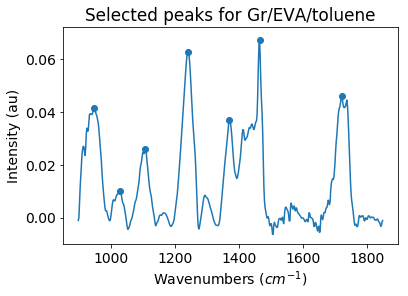

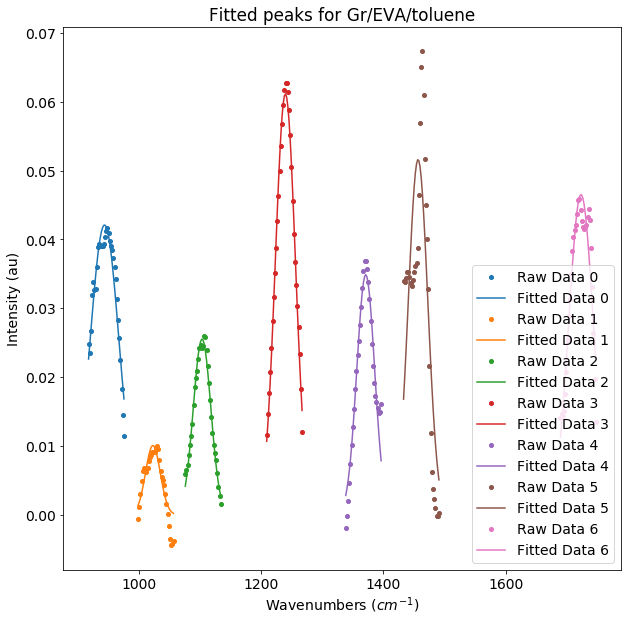

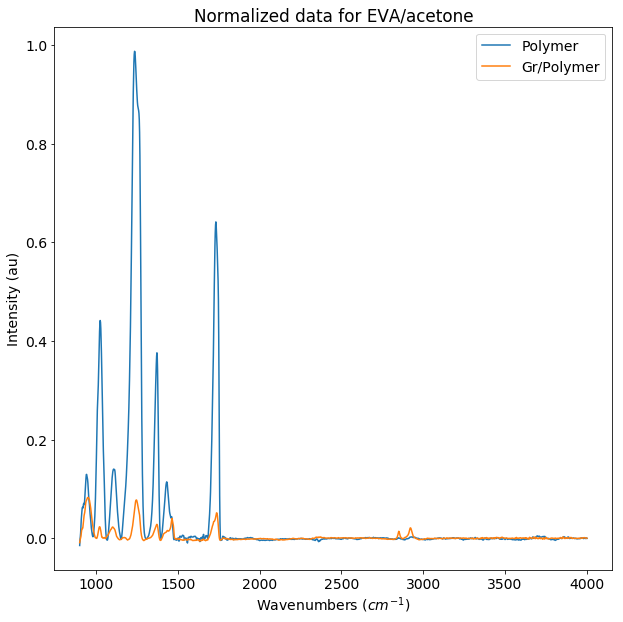

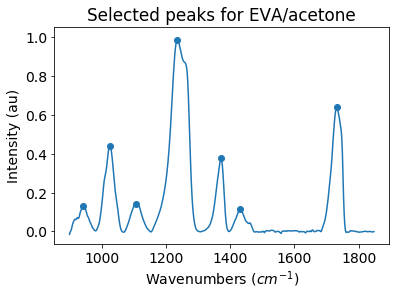

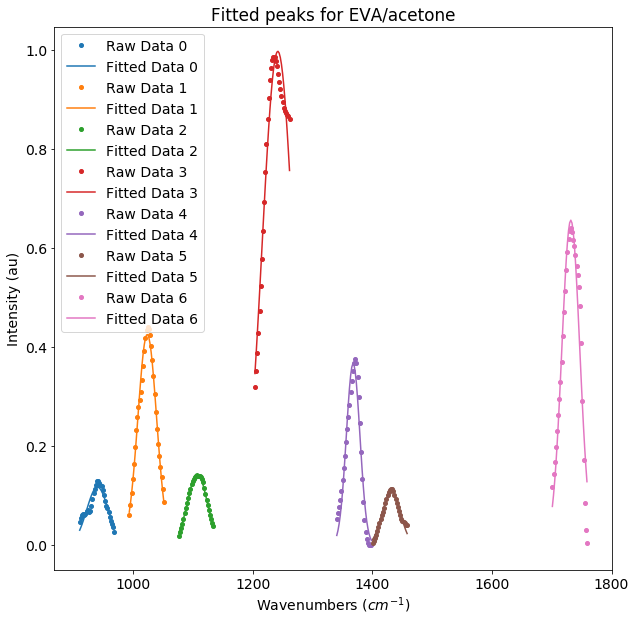

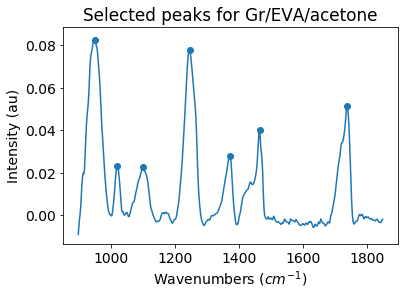

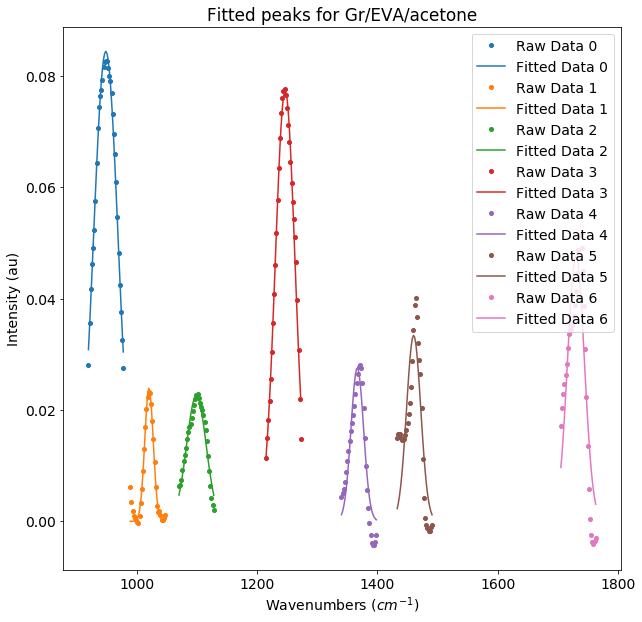

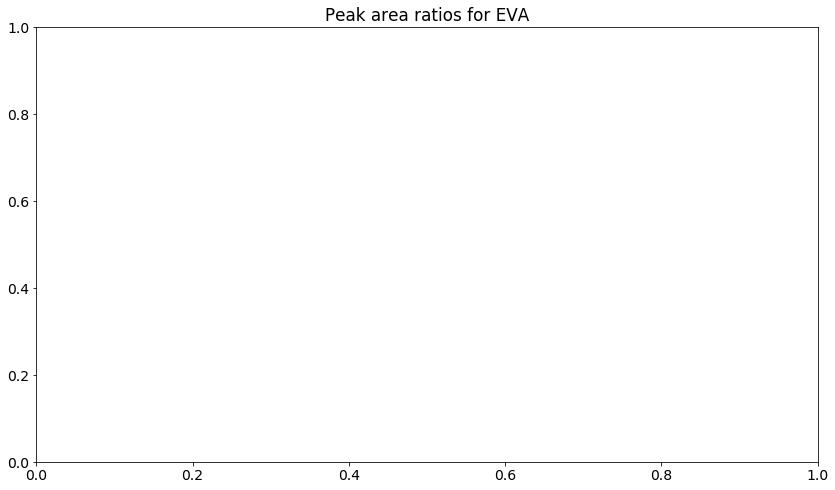

In [168]:
#Code to calculate peak area ratios between polymer : polymer+gr via Gaussian fits for IRRAS data for EVA. Plots ratios 
# over fitted peak frequency

# import packages
%matplotlib inline
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd; from scipy.optimize import curve_fit
from scipy.signal import find_peaks; import matplotlib.lines as mlines; plt.rcParams.update({'font.size': 14});

# Define equations for single Gaussian peak
def gaussS(x,a,x0,sigma):
    y=a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
# Define equations for multiple Gaussian peaks
def gaussM(x,*params):
    y=np.zeros_like(x); params=np.array(params);
    for i in range(0,params[0,:].size,1):
        a=params[0,i]; x0=params[1,i]; sigma=params[2,i];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
# Define equation for area under Gaussian peak
def gaussArea(a,sigma):
    return a*sigma*np.pi**(0.5)

# Initialize fitted parameter and area dictionaries to be later filled. Enter solvent names
masterParams={}; fPolyParams={}; fPolyArea={}; fGrParams={}; fGrArea={};
solvents=['trichlorobenzene','toluene','acetone'];

for counter,name in enumerate(solvents):
    # Load cleaned IRRAS data. Normalize data to pre-determined peak and select frequency range of interest
    path='C:\\Users\\acarr.BNL\\Documents\\Data\\IRRAS\\Corrected Data\\';
    irPoly=np.genfromtxt(path+'EVA_'+name+'_fixed.csv',delimiter=',');
    irGr=np.genfromtxt(path+'Gr_EVA_'+name+'_fixed.csv',delimiter=',');
    idx=np.where(irPoly[:,0]<955)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1]; idx2=np.where(irPoly[:,0]<1850)[0][-1];
    
    # Optional: Plot IRRAS data to confirm normalization and range selection worked correctly
    plt.figure(figsize=(10,10)); plt.title('Normalized data for EVA/'+name);
    plt.plot(irPoly[:,0],c1*irPoly[:,1],label='Polymer'); plt.plot(irGr[:,0],irGr[:,1],label='Gr/Polymer'); plt.legend();
    plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
    
    # Rename selected data reigon x and y for convenience. Find peaks using min peak amplitude and horizontal distance
    x=irPoly[:idx2,0]; y=c1*irPoly[:idx2,1];
    idx3=find_peaks(y,height=0.01,distance=30);
    # Optional: Plot IRRAS data and selected peaks to change peak finder function
    plt.figure();plt.title('Selected peaks for EVA/'+name);
    plt.xlabel(r'Wavenumbers $(cm^{-1})$');plt.ylabel('Intensity (au)');
    plt.plot(x,y); plt.scatter(x[idx3[0][:]],y[idx3[0][:]]); 
    
    # Load found peak heights and centers into amplitude and center arrays. Generate peak width array assuming all peak
    # sigmas are 10. Stakc arrays into initial parameters array
    amp=y[idx3[0][:]]; cen=x[idx3[0][:]]; sig=np.zeros_like(idx3[0][:])+10;
    initParams=np.vstack((amp,cen,sig));
    
    # Initialize fitted parameters and peak area dictionaries
    # Optional: Set up figure for fitted peak plotting
    plt.figure(figsize=(10,10));plt.title('Fitted peaks for EVA/'+name); 
    plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
    fPolyParams={}; fPolyArea={}; 
    for n in range(0,initParams.shape[1]):
        # For each found peak, select parameters from initial parameters array. Select x and y data for peak using
        # span = 30. Fit x and y data for peak using single Gaussian peak function and initial params as guesses.
        p=initParams[:,n]; center=p[1]; span=30;
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        # Optional: plot raw and fitted data to check peak fitting success
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend();
        # Load fitted params into dictionaries using both solvent and peak number as dict key
        masterParams[n,name]=params[1]; fPolyArea[n,name]=gaussArea(params[0],params[2]);
    
    # Repeat entire process for graphene+polymer data using same methodology
    plt.figure(); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
    idx2=np.where(irGr[:,0]<1850)[0][-1];
    x=irGr[:idx2,0]; y=irGr[:idx2,1];
    idx3=find_peaks(y,height=0.01,distance=30);
    plt.plot(x,y); plt.scatter(x[idx3[0][:]],y[idx3[0][:]]); plt.title('Selected peaks for Gr/EVA/'+name);
    amp=y[idx3[0][:]]; cen=x[idx3[0][:]]; sig=np.zeros_like(idx3[0][:])+10;
    initParams=np.vstack((amp,cen,sig));

    plt.figure(figsize=(10,10));plt.title('Fitted peaks for Gr/EVA/'+name); 
    plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
    fGrParams={}; fGrArea={};
    for n in range(0,initParams.shape[1]):
        p=initParams[:,n]; center=p[1]; span=30;
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend(); 
        fGrArea[n,name]=gaussArea(params[0],params[2]);
    
    # Calculate peak area ratio polymer : gr+polymer and load into area dictionary
    for l in range(0,len(fGrArea)):
        masterArea[l,name]=fPolyArea[l,name]/fGrArea[l,name]

# Plot final peak area ratios over peak frequency for each solvent using correct shape and color
fig=plt.figure(figsize=(14,8)); plt.title('Peak area ratios for EVA'); sz=9;
for p in range(0,len(masterParams)):
    col='C'+str(p);
    plt.plot(masterParams[p],masterArea[p,'trichlorobenzene'],'o',ms=sz,color=col);
    plt.plot(masterParams[p],masterArea[p,'toluene'],'^',ms=sz,color=col);
    plt.plot(masterParams[p],masterArea[p,'acetone'],'s',ms=sz,color=col);
    plt.axvline(masterParams[p],color='k',linewidth=0.8)
plt.xlabel(r'Frequency $(cm^{-1})$');plt.ylabel('Polymer : Gr+polymer peak area ratio');plt.xticks(np.arange(925,1825,75));
trichloro=mlines.Line2D([],[],color='k',marker='o',linestyle='',ms=8,label='EVA/Trichlorobenzene');
acetone=mlines.Line2D([],[],color='k',marker='^',linestyle='',ms=8,label='EVA/acetone');
tol=mlines.Line2D([],[],color='k',marker='s',linestyle='',ms=8,label='EVA/Toluene');
plt.legend(handles=[trichloro,acetone,tol]);

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

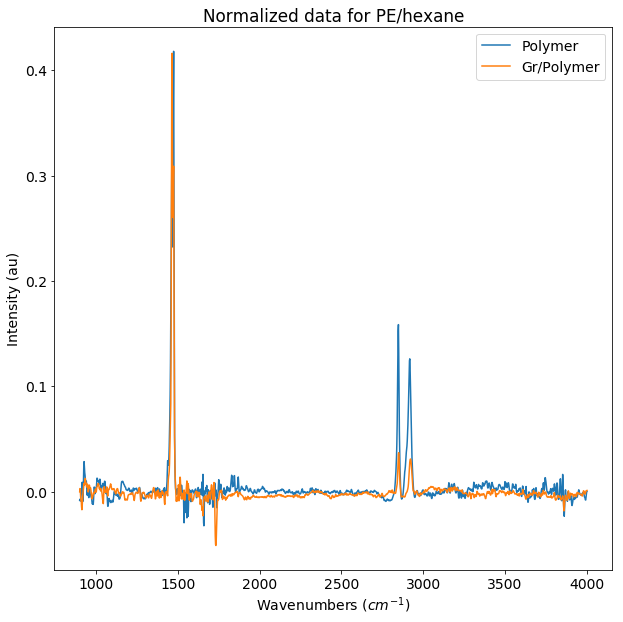

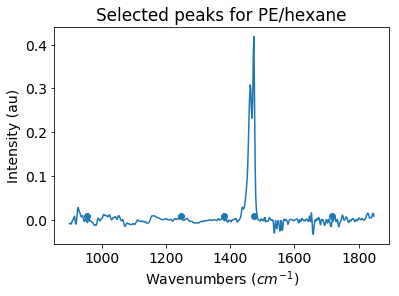

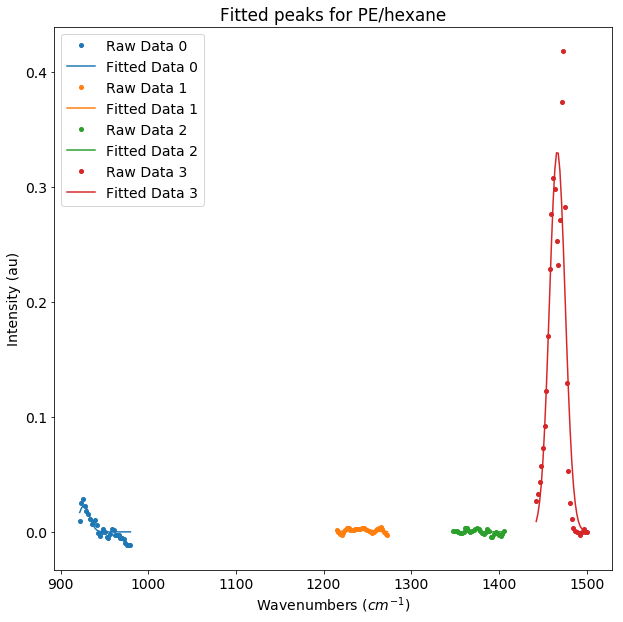

In [140]:
# Code to calculate peak area ratios between PE without and with graphene using Gaussian peak fits

# Import necessary packages. Define single peak Gaussian, multiple peak Gaussian, and area under Gaussian peak equations
%matplotlib inline
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd; from scipy.optimize import curve_fit
from scipy.signal import find_peaks; import matplotlib.lines as mlines; plt.rcParams.update({'font.size': 14});

def gaussS(x,a,x0,sigma):
    y=a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
def gaussM(x,*params):
    y=np.zeros_like(x); params=np.array(params);
    for i in range(0,params[0,:].size,1):
        a=params[0,i]; x0=params[1,i]; sigma=params[2,i];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
def gaussArea(a,sigma):
    return a*sigma*np.pi**(0.5)

# Define path for data loading and solvent. Initialize fitted data dictionaries
path='C:\\Users\\acarr.BNL\\Documents\\Data\\IRRAS\\Corrected Data\\'; 
name='hexane'; freqHex={}; fPolyAreaHex={}; fGrAreaHex={};
irPoly=np.genfromtxt(path+'PE_'+name+'_fixed.csv',delimiter=',');
irGr=np.genfromtxt(path+'Gr_PE_'+name+'_fixed.csv',delimiter=',');
idx=np.where(irPoly[:,0]<1460)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1]; idx2=np.where(irPoly[:,0]<1850)[0][-1];
# Optional: Plot normalized/selected data to check
plt.figure(figsize=(10,10)); plt.title('Normalized data for PE/'+name);
plt.plot(irPoly[:,0],c1*irPoly[:,1],label='Polymer'); plt.plot(irGr[:,0],irGr[:,1],label='Gr/Polymer'); plt.legend();
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
# Rename IR data to x and y for convenience. Enter peak centers. Set all peak widths to 10 and amplitudes to 0.01.
cen=np.array([953,1245,1379,1473,1718]); amp=np.zeros_like(cen)+0.01; sig=np.zeros_like(cen)+10;
initParams=np.vstack((amp,cen,sig));
# Optional: Plot data and selected peaks to check chosen peaks
plt.figure(); plt.title('Selected peaks for PE/'+name);
x=irPoly[:idx2,0]; y=c1*irPoly[:idx2,1];
plt.plot(x,y); plt.scatter(cen,amp); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

plt.figure(figsize=(10,10));plt.title('Fitted peaks for PE/'+name); 
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
for n in range(0,initParams.shape[1]):
    # For each found peak, select peak params and center. Select frequency range to isolate only the peak. Fit peak
    # data to single Gaussian function.
    p=initParams[:,n]; center=p[1]; span=30;
    if np.isnan(center)==False:
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        # Optional: Plot fitted and raw data to check fitting process
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend();
        # Load fitted params into dictionary. Calculate and load peak area into dictionary
        freqHex[n]=params[1]; fPolyAreaHex[n]=gaussArea(params[0],params[2]);
    else:
        freqHex[n]=np.nan; fPolyAreaHex[n]=np.nan;

plt.figure(); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
# Repeat entire process for Gr+polymer
cen=np.array([np.nan,1245,1379,1473,1718]); amp=np.zeros_like(cen)+0.01; sig=np.zeros_like(cen)+10;
idx2=np.where(irGr[:,0]<1850)[0][-1]; x=irGr[:idx2,0]; y=irGr[:idx2,1];
plt.plot(x,y); plt.scatter(cen,amp); plt.title('Selected peaks for Gr/PE/'+name);
initParams=np.vstack((amp,cen,sig));

plt.figure(figsize=(10,10)); plt.title('Fitted peaks for Gr/PE/'+name); 
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
for n in range(0,initParams.shape[1]):
    # For each found peak, select peak params and center. Select frequency range to isolate only the peak. Fit peak
    # data to single Gaussian function.
    p=initParams[:,n]; center=p[1]; span=30;
    if np.isnan(center)==False:
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend();
        fGrAreaHex[n]=gaussArea(params[0],params[2]);
    else:
        fGrAreaHex[n]=np.nan;

name='toluene'; freqTol={}; fPolyAreaTol={}; fGrAreaTol={};
irPoly=np.genfromtxt(path+'PE_'+name+'_fixed.csv',delimiter=',');
irGr=np.genfromtxt(path+'Gr_PE_'+name+'_fixed.csv',delimiter=',');
idx=np.where(irPoly[:,0]<1460)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1]; idx2=np.where(irPoly[:,0]<1850)[0][-1];
# Optional: Plot normalized/selected data to check
plt.figure(figsize=(10,10)); plt.title('Normalized data for PE/'+name);
plt.plot(irPoly[:,0],c1*irPoly[:,1],label='Polymer'); plt.plot(irGr[:,0],irGr[:,1],label='Gr/Polymer'); plt.legend();
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
# Rename IR data to x and y for convenience. Enter peak centers. Set all peak widths to 10 and amplitudes to 0.01.
cen=np.array([953,np.nan,np.nan,np.nan,np.nan,1373,1461]); amp=np.zeros_like(cen)+0.01; sig=np.zeros_like(cen)+10;
initParams=np.vstack((amp,cen,sig));
# Optional: Plot data and selected peaks to check chosen peaks
plt.figure(); plt.title('Selected peaks for PE/'+name);
x=irPoly[:idx2,0]; y=c1*irPoly[:idx2,1]; plt.plot(x,y); plt.scatter(cen,amp); 
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

plt.figure(figsize=(10,10)); plt.title('Fitted peaks for PE/'+name); 
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
for n in range(0,initParams.shape[1]):
    # For each found peak, select peak params and center. Select frequency range to isolate only the peak. Fit peak
    # data to single Gaussian function.
    p=initParams[:,n]; center=p[1]; span=30;
    if np.isnan(center)==False:
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        # Optional: Plot fitted and raw data to check fitting process
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend();
        # Load fitted params into dictionary. Calculate and load peak area into dictionary
        freqTol[n]=params[1]; fPolyAreaTol[n]=gaussArea(params[0],params[2]);
    else:
        freqTol[n]=np.nan; fPolyAreaTol[n]=np.nan;

plt.figure(); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
# Repeat entire process for Gr+polymer
cen=np.array([953,1021,1103,1160,1251,1373,1461]); amp=np.zeros_like(cen)+0.01; sig=np.zeros_like(cen)+10;
idx2=np.where(irGr[:,0]<1850)[0][-1]; x=irGr[:idx2,0]; y=irGr[:idx2,1];
plt.plot(x,y); plt.scatter(cen,amp); plt.title('Selected peaks for Gr/PE/'+name);
initParams=np.vstack((amp,cen,sig));

plt.figure(figsize=(10,10)); plt.title('Fitted peaks for Gr/PE/'+name); 
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
for n in range(0,initParams.shape[1]):
    # For each found peak, select peak params and center. Select frequency range to isolate only the peak. Fit peak
    # data to single Gaussian function.
    p=initParams[:,n]; center=p[1]; span=30;
    if np.isnan(center)==False:
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend();
        fGrAreaTol[n]=gaussArea(params[0],params[2]);
    else:
        fGrAreaTol[n]=np.nan;

name='ethylbenzene'; freqEthyl={}; fPolyAreaEthyl={}; fGrAreaEthyl={};
irPoly=np.genfromtxt(path+'PE_'+name+'_fixed.csv',delimiter=',');
irGr=np.genfromtxt(path+'Gr_PE_'+name+'_fixed.csv',delimiter=',');
idx=np.where(irPoly[:,0]<1460)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1]; idx2=np.where(irPoly[:,0]<1850)[0][-1];
# Optional: Plot normalized/selected data to check
plt.figure(figsize=(10,10)); plt.title('Normalized data for PE/'+name);
plt.plot(irPoly[:,0],c1*irPoly[:,1],label='Polymer'); plt.plot(irGr[:,0],irGr[:,1],label='Gr/Polymer'); plt.legend();
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
# Rename IR data to x and y for convenience. Enter peak centers. Set all peak widths to 10 and amplitudes to 0.01.
cen=np.array([955,np.nan,1106,1154,1262,1377,1470,np.nan,1723]); amp=np.zeros_like(cen)+0.01; sig=np.zeros_like(cen)+10;
initParams=np.vstack((amp,cen,sig));
# Optional: Plot data and selected peaks to check chosen peaks
plt.figure(); plt.title('Selected peaks for PE/'+name);
x=irPoly[:idx2,0]; y=c1*irPoly[:idx2,1];
plt.plot(x,y); plt.scatter(cen,amp); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

plt.figure(figsize=(10,10)); plt.title('Fitted peaks for PE/'+name); 
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
for n in range(0,initParams.shape[1]):
    # For each found peak, select peak params and center. Select frequency range to isolate only the peak. Fit peak
    # data to single Gaussian function.
    p=initParams[:,n]; center=p[1]; span=30;
    if np.isnan(center)==False:
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        # Optional: Plot fitted and raw data to check fitting process
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend();
        # Load fitted params into dictionary. Calculate and load peak area into dictionary
        freqEthyl[n]=params[1]; fPolyAreaEthyl[n]=gaussArea(params[0],params[2]);
    else:
        freqEthyl[n]=np.nan; fPolyAreaEthyl[n]=np.nan;

plt.figure(); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
# Repeat entire process for Gr+polymer
cen=np.array([np.nan,1017,1106,np.nan,1262,1377,1470,np.nan,1723]); amp=np.zeros_like(cen)+0.01; sig=np.zeros_like(cen)+10;
idx2=np.where(irGr[:,0]<1850)[0][-1]; x=irGr[:idx2,0]; y=irGr[:idx2,1];
plt.plot(x,y); plt.scatter(cen,amp); plt.title('Selected peaks for Gr/PE/'+name);
initParams=np.vstack((amp,cen,sig));

plt.figure(figsize=(10,10)); plt.title('Fitted peaks for Gr/PE/'+name); 
plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
for n in range(0,initParams.shape[1]):
    # For each found peak, select peak params and center. Select frequency range to isolate only the peak. Fit peak
    # data to single Gaussian function.
    p=initParams[:,n]; center=p[1]; span=30;
    if np.isnan(center)==False:
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        plt.legend();
        fGrAreaEthyl[n]=gaussArea(params[0],params[2]);
    else:
        fGrAreaEthyl[n]=np.nan;
    
fig=plt.figure('master',figsize=(14,8)); plt.title('Peak area ratios for PE');
plt.xlabel(r'Frequency $(cm^{-1})$'); plt.ylabel('Polymer : Gr+polymer peak area ratio');
sz=9;
col=['C'+str(n0) for n0 in freqEthyl];
_=[plt.plot(freqHex[n],fPolyAreaHex[n]/fGrAreaHex[n],'o',ms=sz,color=col[n]) for n in freqHex];
_=[plt.plot(freqTol[n],fPolyAreaTol[n]/fGrAreaTol[n],'^',ms=sz,color=col[n]) for n in freqTol];
_=[plt.plot(freqEthyl[n],fPolyAreaEthyl[n]/fGrAreaEthyl[n],'s',ms=sz,color=col[n]) for n in freqEthyl];
_=[plt.axvline(freqEthyl[n],color='k',linewidth=0.8) for n in freqEthyl];

plt.xticks(np.arange(900,1800,50));
hexane=mlines.Line2D([],[],color='k',marker='o',linestyle='',ms=8,label='PE/hexane');
toluene=mlines.Line2D([],[],color='k',marker='^',linestyle='',ms=8,label='PE/toluene');
ethyl=mlines.Line2D([],[],color='k',marker='s',linestyle='',ms=8,label='PE/ethylbenzene');
plt.legend(handles=[hexane,toluene,ethyl]);

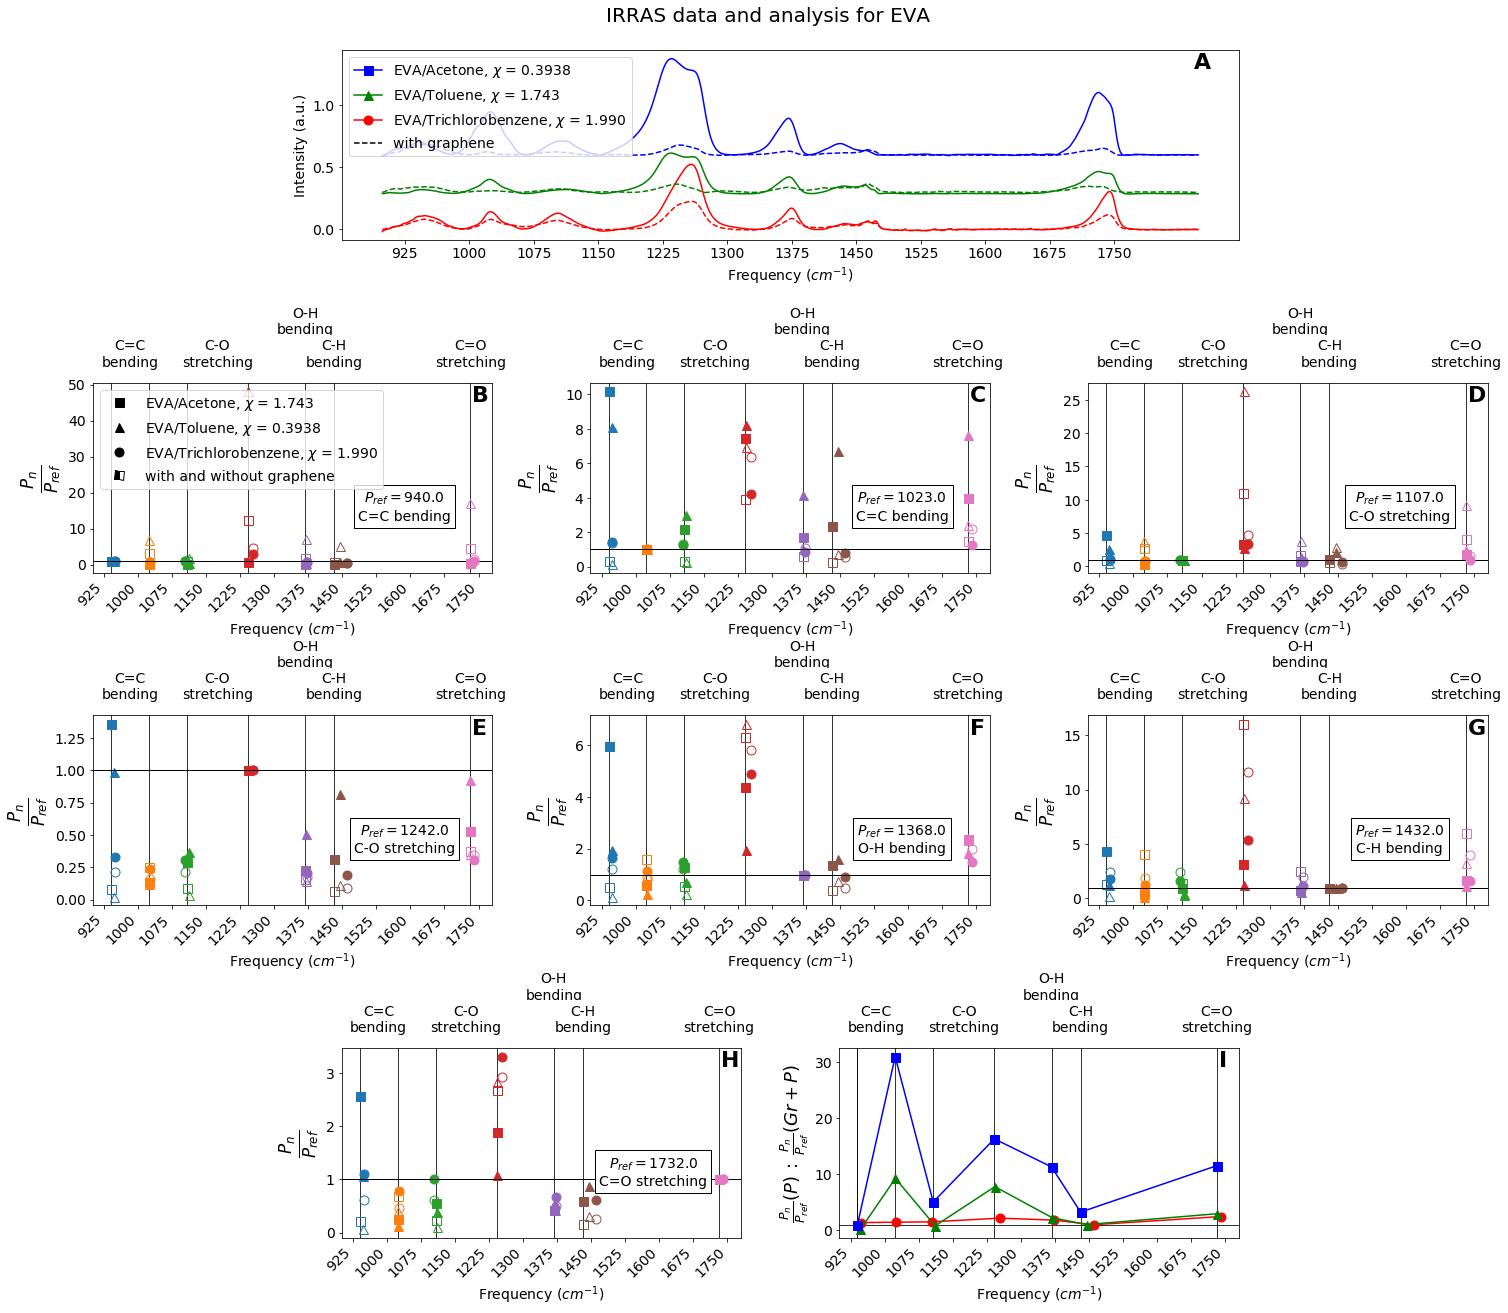

In [5]:
#Code to calculate peak area ratios between polymer(peak n):polymer(peak ref) and gr+polymer(peak n):gr+polymer(peak ref)
# via Gaussian fits of IRRAS data. Plots both ratios over fitted peak center frequency. Generates a new plot for each new
# reference peak, ie repeated small multiple style plot

# EVA
%matplotlib inline

import matplotlib.pyplot as plt; import numpy as np; import pandas as pd; from scipy.optimize import curve_fit
from scipy.signal import find_peaks; import matplotlib.lines as mlines; plt.rcParams.update({'font.size': 14});
import matplotlib.transforms as transforms; import string

def gaussS(x,a,x0,sigma):
    y=a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
def gaussM(x,*params):
    y=np.zeros_like(x); params=np.array(params);
    for i in range(0,params[0,:].size,1):
        a=params[0,i]; x0=params[1,i]; sigma=params[2,i];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
def gaussArea(a,sigma):
    return a*sigma*np.pi**(0.5)

masterParams={}; fPolyParams={}; fPolyArea={}; fGrParams={}; fGrArea={};
solvents=['trichlorobenzene','toluene','acetone'];

for counter,name in enumerate(solvents):
    path='C:\\Users\\acarr.BNL\\Documents\\Data\\IRRAS\\Corrected Data\\';
    irPoly=np.genfromtxt(path+'EVA_'+name+'_fixed.csv',delimiter=',');
    irGr=np.genfromtxt(path+'Gr_EVA_'+name+'_fixed.csv',delimiter=',');
    # Normalize data to pre-detemrined peak, consider frequency range of interest
    idx=np.where(irPoly[:,0]<1460)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1]; idx2=np.where(irPoly[:,0]<1850)[0][-1];

    #plt.figure(figsize=(10,10)); plt.title('Normalized data for EVA/'+name);
    #plt.plot(irPoly[:,0],c1*irPoly[:,1],label='Polymer'); plt.plot(irGr[:,0],irGr[:,1],label='Gr/Polymer'); plt.legend();
    #plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

    #plt.figure(); plt.title('Selected peaks for EVA/'+name);
    x=irPoly[:idx2,0]; y=c1*irPoly[:idx2,1];
    idx3=find_peaks(y,height=0.01,distance=30);
    #plt.plot(x,y); plt.scatter(x[idx3[0][:]],y[idx3[0][:]]); 
    #plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

    amp=y[idx3[0][:]]; cen=x[idx3[0][:]]; sig=np.zeros_like(idx3[0][:])+10;
    initParams=np.vstack((amp,cen,sig));

    #plt.figure(figsize=(10,10));
    for n in range(0,initParams.shape[1]):
        p=initParams[:,n]; center=p[1]; span=30;
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        #plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        #plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        #plt.legend(); 
        masterParams[n,name]=params[1]; fPolyArea[n,name]=gaussArea(params[0],params[2]);
    #plt.title('Fitted peaks for EVA/'+name); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

    #plt.figure(); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
    idx2=np.where(irGr[:,0]<1850)[0][-1];
    x=irGr[:idx2,0]; y=irGr[:idx2,1];
    idx3=find_peaks(y,height=0.01,distance=30);
    #plt.plot(x,y); plt.scatter(x[idx3[0][:]],y[idx3[0][:]]); plt.title('Selected peaks for Gr/EVA/'+name);
    amp=y[idx3[0][:]]; cen=x[idx3[0][:]]; sig=np.zeros_like(idx3[0][:])+10;
    initParams=np.vstack((amp,cen,sig));

    #plt.figure(figsize=(10,10));
    for n in range(0,initParams.shape[1]):
        p=initParams[:,n]; center=p[1]; span=30;
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
        s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
        #plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
        #plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
        #plt.legend(); 
        fGrArea[n,name]=gaussArea(params[0],params[2]);
    #plt.title('Fitted peaks for Gr/EVA/'+name); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

# Generate figure with subplots. Load axes into array for iteration    
_=plt.figure(figsize=(25,20));
ax0=plt.subplot2grid((4,6),(0,1),colspan=4,rowspan=1); 
ax1=plt.subplot2grid((4,6),(1,0),colspan=2,rowspan=1); ax2=plt.subplot2grid((4,6),(1,2),colspan=2,rowspan=1); 
ax3=plt.subplot2grid((4,6),(1,4),colspan=2,rowspan=1); 
ax4=plt.subplot2grid((4,6),(2,0),colspan=2,rowspan=1); ax5=plt.subplot2grid((4,6),(2,2),colspan=2,rowspan=1); 
ax6=plt.subplot2grid((4,6),(2,4),colspan=2,rowspan=1); 
ax7=plt.subplot2grid((4,6),(3,1),colspan=2,rowspan=1); ax8=plt.subplot2grid((4,6),(3,3),colspan=2,rowspan=1);
axs=[ax1,ax2,ax3,ax4,ax5,ax6,ax7]; refPeak=int(len(masterParams)/len(solvents)); numPeaks=refPeak;

# Initialize area ratio arrays. Enter bonding information to be used as labels for plots (nInfoB) and to be used as labels
# for vertical lines drawn at each peak (bInfoL). For vertical line labels, enter x and y coordinate data
sz=9; xaxis=np.arange(925,1825,75); areaRatioTri=[]; areaRatioTol=[]; areaRatioAce=[]; freqTri=[]; freqTol=[]; freqAce=[];
bInfoB=['C=C bending','C=C bending','C-O stretching','C-O stretching','O-H bending','C-H bending','C=O stretching'];
bInfoL=['C=C\nbending','C-O\nstretching','O-H\nbending','C-H\nbending','C=O\nstretching'];
bInfoXLoc=np.array([np.mean([masterParams[0,'acetone'],masterParams[1,'acetone']]),
                  np.mean([masterParams[2,'acetone'],masterParams[3,'acetone']]),
                  masterParams[4,'acetone'],masterParams[5,'acetone'],masterParams[6,'acetone']]);
bInfoYLoc=np.array([1.15,1.15,1.32,1.15,1.15]);
for p in range(0,refPeak):
    # For each reference peak, label the subplot with bonding info and axes labels
    s=str(round(masterParams[p,'acetone']))+'\n'+bInfoB[p];
    _=axs[p].set_ylabel(r'$\frac{P_{n}}{P_{ref}}$',fontsize=24);
    _=axs[p].set_xlabel(r'Frequency $(cm^{-1})$'); 
    _=axs[p].text(0.78,0.35,r'$P_{ref} = $'+s,horizontalalignment='center',verticalalignment='center',
                  transform=axs[p].transAxes,bbox=dict(boxstyle='square',facecolor='white'));
    for q in range(0,numPeaks):
        # For each peak, drawn vertical lines. Draw horizontal line at 1 for reference. Plot area ratio data using correct
        # shape based on solvent. Vary color between peaks. Load area ratio data into array for ratio ratio plot. On first
        # iteration, set x axis ticks and rotate labels
        col='C'+str(q); 
        _=axs[p].axvline(masterParams[q,'acetone'],color='k',linewidth=0.8); _=axs[p].axhline(1,color='k',lw=0.8);
        sol='trichlorobenzene';  
        _=axs[p].plot(masterParams[q,sol],fPolyArea[q,sol]/fPolyArea[p,sol],ls='',marker='o',fillstyle='none',
                      c=col,markersize=sz);
        _=axs[p].plot(masterParams[q,sol],fGrArea[q,sol]/fGrArea[p,sol],ls='',marker='o',fillstyle='full',
                      c=col,markersize=sz);
        areaRatioTri.append(fPolyArea[q,sol]/fGrArea[q,sol]); freqTri.append(masterParams[q,sol]);
        sol='toluene';
        _=axs[p].plot(masterParams[q,sol],fPolyArea[q,sol]/fPolyArea[p,sol],ls='',marker='^',fillstyle='none',
                      c=col,markersize=sz);
        _=axs[p].plot(masterParams[q,sol],fGrArea[q,sol]/fGrArea[p,sol],ls='',marker='^',fillstyle='full',
                      c=col,markersize=sz);
        areaRatioTol.append(fPolyArea[q,sol]/fGrArea[q,sol]); freqTol.append(masterParams[q,sol]);
        sol='acetone';
        _=axs[p].plot(masterParams[q,sol],fPolyArea[q,sol]/fPolyArea[p,sol],ls='',marker='s',fillstyle='none',
                      c=col,markersize=sz);
        _=axs[p].plot(masterParams[q,sol],fGrArea[q,sol]/fGrArea[p,sol],ls='',marker='s',fillstyle='full',
                      c=col,markersize=sz);
        areaRatioAce.append(fPolyArea[q,sol]/fGrArea[q,sol]); freqAce.append(masterParams[q,sol]);
        if q==0:
            _=axs[p].set_xticks(xaxis); _=axs[p].set_xticklabels(xaxis,rotation=45,ha='right');
# For each subplot, label each vertical line with the correct bonding information
_=[ax.text(xLoc,yLoc,string,horizontalalignment='center',verticalalignment='center',
           transform=transforms.blended_transform_factory(ax.transData,ax.transAxes),
           bbox=dict(boxstyle='square',facecolor='white',edgecolor='white')) 
   for xLoc,yLoc,string in zip(bInfoXLoc,bInfoYLoc,bInfoL) for ax in axs];

trichloro=mlines.Line2D([],[],color='k',marker='o',linestyle='',ms=sz,label='EVA/Trichlorobenzene, $\chi$ = 1.990');
acetone=mlines.Line2D([],[],color='k',marker='s',linestyle='',ms=sz,label='EVA/Acetone, $\chi$ = 1.743');
tol=mlines.Line2D([],[],color='k',marker='^',linestyle='',ms=sz,label='EVA/Toluene, $\chi$ = 0.3938'); 
fs=mlines.Line2D([],[],marker='s',linestyle='',ms=sz,fillstyle='left',color='black',markerfacecoloralt='white',
                 label='with and without graphene');
axs[0].legend(handles=[acetone,tol,trichloro,fs],loc=2);

# Plot normalized polymer and gr+polymer IR data. Create legend and correct axes labels
space=0.3; col=['r','g','b']; shapes=['o','^','s'];
for n,name in enumerate(solvents):
    irPoly=np.genfromtxt(path+'EVA_'+name+'_fixed.csv',delimiter=',');
    irGr=np.genfromtxt(path+'Gr_EVA_'+name+'_fixed.csv',delimiter=',');
    idx=np.where(irPoly[:,0]<1460)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1]; idx2=np.where(irPoly[:,0]<1850)[0][-1]; 
    _=ax0.plot(irPoly[:idx2,0],c1*irPoly[:idx2,1]+n*space,color=col[n]); 
    _=ax0.plot(irGr[:idx2,0],irGr[:idx2,1]+n*space,color=col[n],ls='--');
trichloro=mlines.Line2D([],[],color='r',marker='o',linestyle='-',ms=sz,label='EVA/Trichlorobenzene, $\chi$ = 1.990');
acetone=mlines.Line2D([],[],color='b',marker='s',linestyle='-',ms=sz,label='EVA/Acetone, $\chi$ = 0.3938');
tol=mlines.Line2D([],[],color='g',marker='^',linestyle='-',ms=sz,label='EVA/Toluene, $\chi$ = 1.743'); 
gr=mlines.Line2D([],[],marker='',linestyle='--',ms=sz,color='black',label='with graphene');
_=ax0.set_xlabel(r'Frequency $(cm^{-1})$'); _=ax0.set_ylabel('Intensity (a.u.)');
_=ax0.legend(handles=[acetone,tol,trichloro,gr],loc=2); _=ax0.set_xticks(xaxis);

# Convert previously used ratio lists into arrays
areaRatioTri=np.asarray(areaRatioTri); areaRatioTol=np.asarray(areaRatioTol); areaRatioAce=np.asarray(areaRatioAce);
freqTri=np.asarray(freqTri); freqTol=np.asarray(freqTol); freqAce=np.asarray(freqAce);
# Draw peak vertical lines and horizontal line at 1. Label peak lines with bonding info. Set axes labels
_=[ax8.axvline(x,color='k',linewidth=0.8) for x in freqAce[:8]]; _=ax8.axhline(1,color='k',lw=0.8);
_=[ax8.text(xLoc,yLoc,string,horizontalalignment='center',verticalalignment='center',
           transform=transforms.blended_transform_factory(ax8.transData,ax8.transAxes),
           bbox=dict(boxstyle='square',facecolor='white',edgecolor='white')) 
   for xLoc,yLoc,string in zip(bInfoXLoc,bInfoYLoc,bInfoL)];
_=ax8.set_ylabel(r'$\frac{P_{n}}{P_{ref}}(P)\::\:\frac{P_{n}}{P_{ref}}(Gr+P)$',fontsize=18);
_=ax8.set_xlabel(r'Frequency $(cm^{-1})$');_=ax8.set_xticks(xaxis);_=ax8.set_xticklabels(xaxis,rotation=45,ha='right');
# Plot peak area ratio ratios data with correct color and marker info
_=ax8.plot(freqTri[:numPeaks],areaRatioTri[:numPeaks],color='r',marker='o',ms=sz,label='EVA/Trichlorobenzene');
_=ax8.plot(freqTol[:numPeaks],areaRatioTol[:numPeaks],color='g',marker='^',ms=sz,label='EVA/Toluene');
_=ax8.plot(freqAce[:numPeaks],areaRatioAce[:numPeaks],color='b',marker='s',ms=sz,label='EVA/Acetone');

# Adjust subplot top, horizontal, and vertical space to make room for bonding information. Add subplot letter labels
axs=[ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8];
for n,ax in enumerate(axs):
    ax.text(0.95,0.9,string.ascii_uppercase[n],transform=ax.transAxes,size=22,weight='bold');

plt.subplots_adjust(top=0.95,hspace=0.75,wspace=0.65);plt.suptitle('IRRAS data and analysis for EVA',fontsize=20);
plt.savefig('C:Users/acarr.BNL/Documents/Figures/IRRAS Paper Figures/IRRAS_EVA_sup.eps',format='eps');

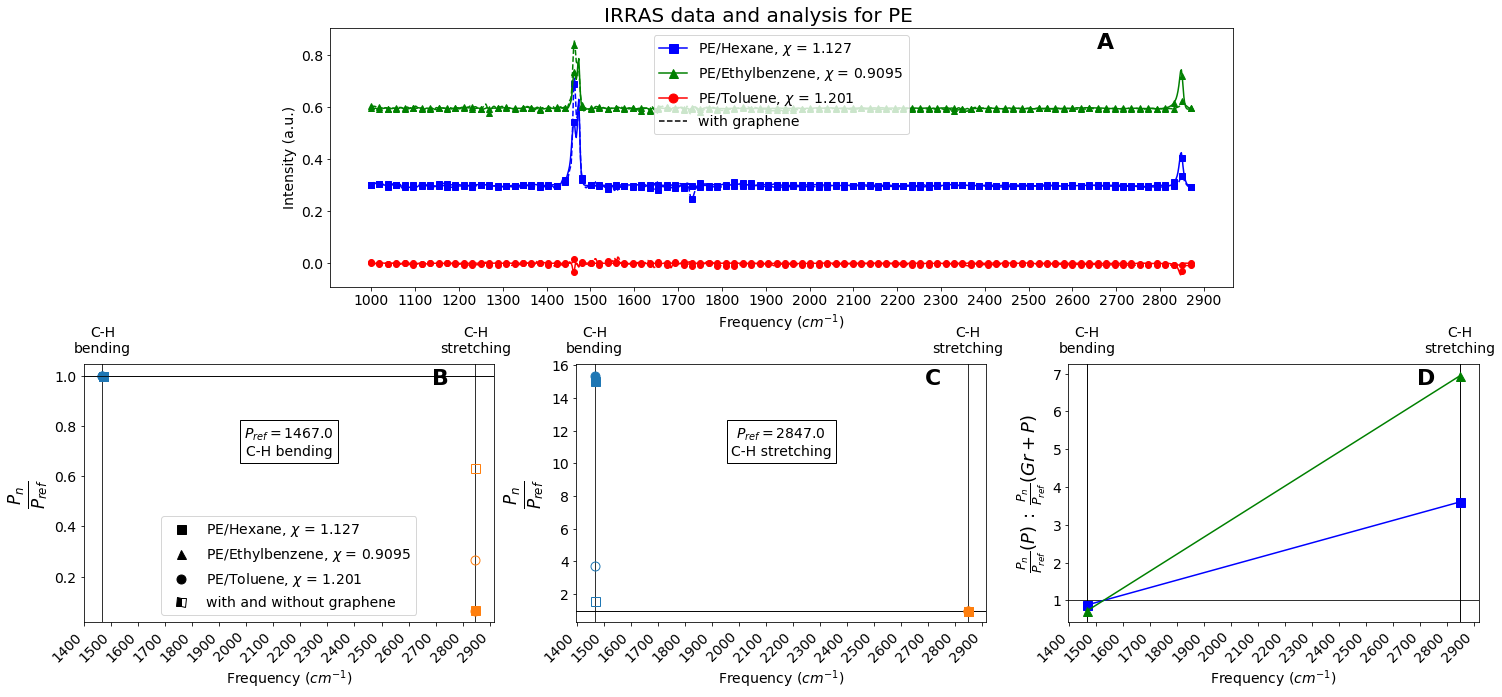

In [8]:
#Code to calculate peak area ratios between polymer(peak n):polymer(peak ref) and gr+polymer(peak n):gr+polymer(peak ref)
# via Gaussian fits of IRRAS data. Plots both ratios over fitted peak center frequency. Generates a new plot for each new
# reference peak, ie repeated small multiple style plot

# PE
%matplotlib inline

import matplotlib.pyplot as plt; import numpy as np; import pandas as pd; from scipy.optimize import curve_fit
from scipy.signal import find_peaks; import matplotlib.lines as mlines; plt.rcParams.update({'font.size': 14});
import matplotlib.transforms as transforms

def gaussS(x,a,x0,sigma):
    y=a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
def gaussM(x,*params):
    y=np.zeros_like(x); params=np.array(params);
    for i in range(0,params[0,:].size,1):
        a=params[0,i]; x0=params[1,i]; sigma=params[2,i];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y
def gaussArea(a,sigma):
    return a*sigma*np.pi**(0.5)

masterParams={}; fPolyParams={}; fPolyArea={}; fGrParams={}; fGrArea={};
solvents=['hexane','ethylbenzene']; #solvents=['hexane','toluene','ethylbenzene'];

for counter,name in enumerate(solvents):
    path='C:\\Users\\acarr.BNL\\Documents\\Data\\IRRAS\\Corrected Data\\';
    irPoly=np.genfromtxt(path+'PE_'+name+'_fixed.csv',delimiter=',');
    irGr=np.genfromtxt(path+'Gr_PE_'+name+'_fixed.csv',delimiter=',');
    # Normalize data to pre-detemrined peak, consider frequency range of interest
    idx=np.where(irPoly[:,0]<1473)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1];

    #plt.figure(figsize=(10,10)); plt.title('Normalized data for PE/'+name);
    #plt.plot(irPoly[:,0],c1*irPoly[:,1],label='Polymer'); plt.plot(irGr[:,0],irGr[:,1],label='Gr/Polymer'); plt.legend();
    #plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

    #plt.figure(); plt.title('Selected peaks for PE/'+name);
    x=irPoly[:,0]; y=c1*irPoly[:,1];
    idx3=find_peaks(y,height=0.1,distance=30);
    #plt.plot(x,y); plt.scatter(x[idx3[0][:]],y[idx3[0][:]]); 
    #plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

    amp=y[idx3[0][:]]; cen=x[idx3[0][:]]; sig=np.zeros_like(idx3[0][:])+10;
    initParams=np.vstack((amp,cen,sig));

    #plt.figure(figsize=(10,10));
    for n in range(0,initParams.shape[1]):
        p=initParams[:,n]; center=p[1]; span=30;
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
    #    s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
    #    plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
    #    plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
    #    plt.legend(); 
        masterParams[n,name]=params[1]; fPolyArea[n,name]=gaussArea(params[0],params[2]);
    #plt.title('Fitted peaks for PE/'+name); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');

    #plt.figure(); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
    x=irGr[:,0]; y=irGr[:,1];
    idx3=find_peaks(y,height=0.02,distance=30);
    #plt.plot(x,y); plt.scatter(x[idx3[0][:]],y[idx3[0][:]]); plt.title('Selected peaks for Gr/PE/'+name);
    amp=y[idx3[0][:]]; cen=x[idx3[0][:]]; sig=np.zeros_like(idx3[0][:])+10;
    initParams=np.vstack((amp,cen,sig));

    #plt.figure(figsize=(10,10));
    for n in range(0,initParams.shape[1]):
        p=initParams[:,n]; center=p[1]; span=30;
        spanIdx1=np.argmax(np.where(x<center-span)); spanIdx2=np.argmax(np.where(x<center+span));
        xPeak=x[spanIdx1:spanIdx2]; yPeak=y[spanIdx1:spanIdx2];
        params,cov=curve_fit(gaussS,xPeak,yPeak,p0=p);
     #   s1='Raw Data '+str(n); s2='Fitted Data '+str(n); col='C'+str(n); sz=4;
     #   plt.plot(xPeak,yPeak,color=col,marker='o',ms=sz,ls='',label=s1); 
     #   plt.plot(xPeak,gaussS(xPeak,*params),color=col,label=s2); 
     #   plt.legend(); 
        fGrArea[n,name]=gaussArea(params[0],params[2]);
    #plt.title('Fitted peaks for Gr/PE/'+name); plt.xlabel(r'Wavenumbers $(cm^{-1})$'); plt.ylabel('Intensity (au)');
# Generate figure with subplots. Load axes into array for iteration    
_=plt.figure(figsize=(25,10));
ax0=plt.subplot2grid((2,6),(0,1),colspan=4,rowspan=1); 
ax1=plt.subplot2grid((2,6),(1,0),colspan=2,rowspan=1); ax2=plt.subplot2grid((2,6),(1,2),colspan=2,rowspan=1);
ax3=plt.subplot2grid((2,6),(1,4),colspan=2,rowspan=1);
axs=[ax1,ax2]; refPeak=int(len(masterParams)/len(solvents)); numPeaks=refPeak;

# Initialize area ratio arrays. Enter bonding information to be used as labels for plots (nInfoB) and to be used as labels
# for vertical lines drawn at each peak (bInfoL). For vertical line labels, enter x and y coordinate data
sz=9; xaxis=np.arange(1400,3000,100); areaRatioHex=[];areaRatioTol=[];areaRatioEthyl=[];freqHex=[];freqTol=[];freqEthyl=[];
bInfoB=['C-H bending','C-H stretching']; bInfoL=['C-H\nbending','C-H\nstretching'];
bInfoXLoc=np.array([masterParams[0,'hexane'],masterParams[1,'hexane']]);
for p in range(0,refPeak):
    # For each reference peak, label the subplot with bonding info and axes labels
    s=str(round(masterParams[p,'hexane']))+'\n'+bInfoB[p];
    _=axs[p].set_ylabel(r'$\frac{P_{n}}{P_{ref}}$',fontsize=24); 
    _=axs[p].set_xlabel(r'Frequency $(cm^{-1})$'); 
    _=axs[p].text(0.5,0.7,r'$P_{ref} = $'+s,horizontalalignment='center',verticalalignment='center',
                  transform=axs[p].transAxes,bbox=dict(boxstyle='square',facecolor='white'));  
    for q in range(0,numPeaks):
        # For each peak, drawn vertical lines. Draw horizontal line at 1 for reference. Plot area ratio data using correct
        # shape based on solvent. Vary color between peaks. Load area ratio data into array for ratio ratio plot. On first
        # iteration, set x axis ticks and rotate labels
        col='C'+str(q); 
        _=axs[p].axvline(masterParams[q,'hexane'],color='k',linewidth=0.8); _=axs[p].axhline(1,color='k',lw=0.8);
        sol='hexane';  
        _=axs[p].plot(masterParams[q,sol],fPolyArea[q,sol]/fPolyArea[p,sol],ls='',marker='o',fillstyle='none',
                      c=col,markersize=sz);
        _=axs[p].plot(masterParams[q,sol],fGrArea[q,sol]/fGrArea[p,sol],ls='',marker='o',fillstyle='full',
                      c=col,markersize=sz);
        areaRatioHex.append(fPolyArea[q,sol]/fGrArea[q,sol]); freqHex.append(masterParams[q,sol]);
        sol='ethylbenzene';
        _=axs[p].plot(masterParams[q,sol],fPolyArea[q,sol]/fPolyArea[p,sol],ls='',marker='s',fillstyle='none',
                      c=col,markersize=sz);
        _=axs[p].plot(masterParams[q,sol],fGrArea[q,sol]/fGrArea[p,sol],ls='',marker='s',fillstyle='full',
                      c=col,markersize=sz);
        areaRatioEthyl.append(fPolyArea[q,sol]/fGrArea[q,sol]); freqEthyl.append(masterParams[q,sol]);
        if q==0:
            _=axs[p].set_xticks(xaxis); _=axs[p].set_xticklabels(xaxis,rotation=45,ha='right');
# For each subplot, label each vertical line with the correct bonding information
_=[ax.text(xLoc,1.09,string,horizontalalignment='center',verticalalignment='center',
           transform=transforms.blended_transform_factory(ax.transData,ax.transAxes),
           bbox=dict(boxstyle='square',facecolor='white',edgecolor='white')) 
   for xLoc,string in zip(bInfoXLoc,bInfoL) for ax in axs];
# Create custom legend and display
hexane=mlines.Line2D([],[],color='k',marker='s',linestyle='',ms=sz,label='PE/Hexane, $\chi$ = 1.127');
ethyl=mlines.Line2D([],[],color='k',marker='^',linestyle='',ms=sz,label='PE/Ethylbenzene, $\chi$ = 0.9095');
tol=mlines.Line2D([],[],color='k',marker='o',linestyle='',ms=sz,label='PE/Toluene, $\chi$ = 1.201'); 
fs=mlines.Line2D([],[],marker='s',linestyle='',ms=sz,fillstyle='left',color='black',markerfacecoloralt='white',
                 label='with and without graphene');
axs[0].legend(handles=[hexane,ethyl,tol,fs],loc=8);

# Plot normalized polymer and gr+polymer IR data on same subplot as peak area ratio anlaysis for convenience. Create legend
# and correct axes labels
space=0.3; col=['r','b','g']; shapes=['o','s','^'];
for n,name in enumerate(['toluene','hexane','ethylbenzene']):
    irPoly=np.genfromtxt(path+'PE_'+name+'_fixed.csv',delimiter=',');
    irGr=np.genfromtxt(path+'Gr_PE_'+name+'_fixed.csv',delimiter=',');
    idx=np.where(irPoly[:,0]<1473)[0][-1]; c1=irGr[idx,1]/irPoly[idx,1];
    _=ax0.plot(irPoly[:,0],c1*irPoly[:,1]+n*space,color=col[n],marker=shapes[n],markevery=10); 
    _=ax0.plot(irGr[:,0],irGr[:,1]+n*space,color=col[n],marker=shapes[n],ls='--',markevery=10);

tol=mlines.Line2D([],[],color='r',marker='o',linestyle='-',ms=sz,label='PE/Toluene, $\chi$ = 1.201'); 
hexane=mlines.Line2D([],[],color='b',marker='s',linestyle='-',ms=sz,label='PE/Hexane, $\chi$ = 1.127');
ethyl=mlines.Line2D([],[],color='g',marker='^',linestyle='-',ms=sz,label='PE/Ethylbenzene, $\chi$ = 0.9095');
gr=mlines.Line2D([],[],marker='',linestyle='--',ms=sz,color='black',label='with graphene');
_=ax0.set_xlabel(r'Frequency $(cm^{-1})$');_=ax0.set_ylabel('Intensity (a.u.)');_=ax0.set_xticks(np.arange(1000,3000,100));
_=ax0.legend(handles=[hexane,ethyl,tol,gr],loc=9); 

# Convert previously used ratio lists into arrays
areaRatioHex=np.asarray(areaRatioHex); areaRatioTol=np.asarray(areaRatioTol); areaRatioEthyle=np.asarray(areaRatioEthyl);
freqHex=np.asarray(freqHex); freqTol=np.asarray(freqTol); freqEthyl=np.asarray(freqEthyl);

_=[ax3.axvline(x0,color='k',linewidth=0.8) for x0 in freqHex]; _=ax3.axhline(1,color='k',lw=0.8); 
_=ax3.set_xticks(xaxis);_=ax3.set_xticklabels(xaxis,rotation=45,ha='right');_=ax3.set_xlabel(r'Frequency $(cm^{-1})$');
_=ax3.set_ylabel(r'$\frac{P_{n}}{P_{ref}}(P)\::\:\frac{P_{n}}{P_{ref}}(Gr+P)$',fontsize=18);
# Plot ratio of ratios data over peak frequency using correct marker shapes and colors
_=ax3.plot(freqHex[:numPeaks],areaRatioHex[:numPeaks],color='b',marker='s',ms=sz,label='PE/Hexane');
_=ax3.plot(freqEthyl[:numPeaks],areaRatioEthyl[:numPeaks],color='g',marker='^',ms=sz,label='PE/Ethylbenzene');
# For each subplot, label vertical lines with correct bonding information at correct x and y positions
_=[ax3.text(xLoc,1.09,string,horizontalalignment='center',verticalalignment='center',
           transform=transforms.blended_transform_factory(ax3.transData,ax3.transAxes),
           bbox=dict(boxstyle='square',facecolor='white',edgecolor='white')) 
   for xLoc,string in zip(bInfoXLoc,bInfoL)];

axs=[ax0,ax1,ax2,ax3];
for n,ax in enumerate(axs):
    ax.text(0.85,0.92,string.ascii_uppercase[n],transform=ax.transAxes,size=22,weight='bold');
    
# Adjust top and space in between plots to make room for bonding labels
plt.subplots_adjust(top=0.95,wspace=0.5,hspace=0.3); plt.suptitle('IRRAS data and analysis for PE',fontsize=20);

In [ ]:
%matplotlib inline
import numpy as np; import matplotlib.pyplot as plt; from math import sqrt

# This code anlayzed Raman spectra for the IRRAS paper results. It loads Raman spot summaries, calculates the 
# error bars, and plots the results for both polymers

path='C:\\Users\\acarr\\Documents\\Data\\Raman Analysis\\';
samplesPE=['PE_toluene_1','PE_hexane_4','PE_ethylbenzene_3',]; rCovPE=[]; rErrPE=[];
for samp in samplesPE:
    A=np.genfromtxt(path+'Gr_'+samp[:-2]+'_spotSummary.csv',delimiter=','); 
    n=A.shape[0]; p=A.sum()/n; mu=n*p; s=sqrt(n*p*(1-p));
    # p = successful trials, n = number of trials, mu = mean, s = standard deviation
    rCovPE.append(mu); rErrPE.append(s);
    print(samp+' coverage = '+str(mu)+' +/- '+str(s))
    
samplesEVA=['EVA_trichlorobenzene_1','EVA_acetone_4','EVA_toluene_1']; rCovEVA=[]; rErrEVA=[];
for samp in samplesEVA:
    A=np.genfromtxt(path+'Gr_'+samp[:-2]+'_spotSummary.csv',delimiter=','); 
    n=A.shape[0]; p=A.sum()/n; mu=n*p; s=sqrt(n*p*(1-p));
    rCovEVA.append(mu); rErrEVA.append(s);
    print(samp+' coverage = '+str(mu)+' +/- '+str(s))

# Plot coverage data with correct error bars
# PE: toluene, hexane, ethylbenzene. EVA: trichlorobenzene, acetone, toluene
chiPE=np.asarray([1.201, 1.127, 0.9095]); chiEVA=np.asarray([1.99, 1.743, 0.3938]);
colors=['r','b','g']; sz=7; plt.grid(True,which='both'); linewidth=1;
for n in range(0,3):
    plt.errorbar(chiPE[n],rCovPE[n],yerr=rErrPE[n],capsize=8,capthick=1.5,ecolor=colors[n],color=colors[n],fmt='o',
                 ms=sz,mew=1.5,lw=linewidth);
    plt.errorbar(chiEVA[n],rCovEVA[n],yerr=rErrEVA[n],capsize=8,capthick=1.5,ecolor=colors[n],color=colors[n],fmt='^',
                 ms=sz,mew=1.5,lw=linewidth);